## Import Library

In [10]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [11]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [12]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train_mclahe'
val_dir = '/content/drive/MyDrive/PI/valid_mclahe'
test_dir = '/content/drive/MyDrive/PI/test_mclahe'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,             # Lebih kecil untuk mempertahankan konteks
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

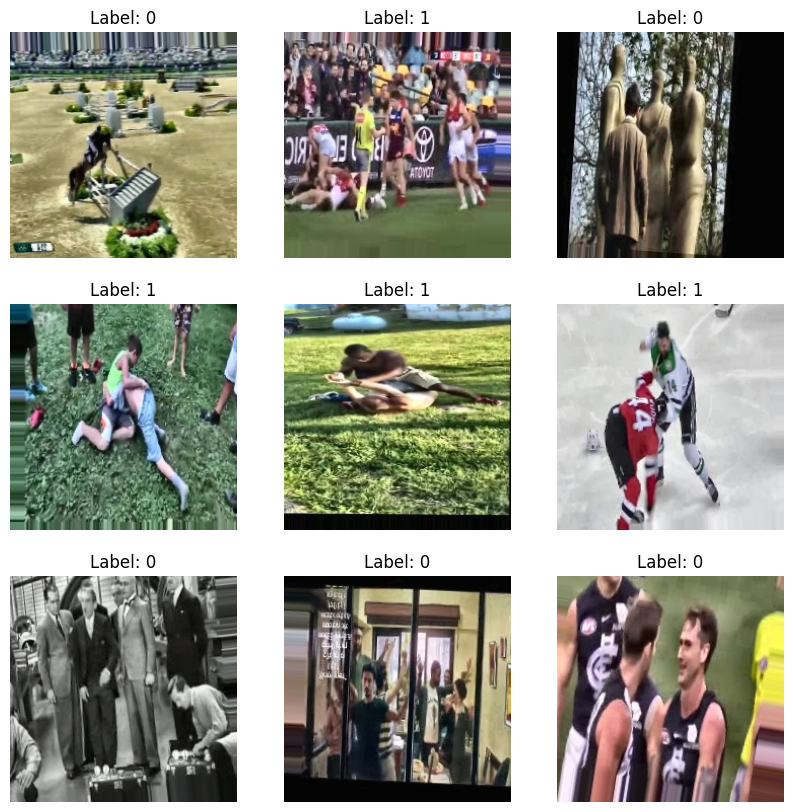

In [13]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [14]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze 40
for layer in base_model.layers[:40]:
    layer.trainable = False
for layer in base_model.layers[40:]:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'MCLAHE_Freeze40_0.0001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [15]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.5569 - loss: 1.4191
Epoch 1: val_accuracy improved from -inf to 0.56818, saving model to MCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 623ms/step - accuracy: 0.5577 - loss: 1.4180 - val_accuracy: 0.5682 - val_loss: 1.1344
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.6844 - loss: 1.1579
Epoch 2: val_accuracy improved from 0.56818 to 0.57500, saving model to MCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 561ms/step - accuracy: 0.6846 - loss: 1.1575 - val_accuracy: 0.5750 - val_loss: 1.0856
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.7324 - loss: 1.0415
Epoch 3: val_accuracy improved from 0.57500 to 0.62727, saving model to MCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 560ms/step - accuracy: 0.7323 - loss: 1.0417 - val_accuracy: 0.6273 - val_loss: 1.0273
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.7525 - loss: 0.9566
Epoch 4: val_accuracy improved from 0.62727 to 0.67500, saving model to MCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 544ms/step - accuracy: 0.7526 - loss: 0.9565 - val_accuracy: 0.6750 - val_loss: 0.9741
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.7599 - loss: 0.9581
Epoch 5: val_accuracy improved from 0.67500 to 0.79545, saving model to MCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 552ms/step - accuracy: 0.7602 - loss: 0.9571 - val_accuracy: 0.7955 - val_loss: 0.8912
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.7964 - loss: 0.8648
Epoch 6: val_accuracy improved from 0.79545 to 0.82727, saving model to MCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 555ms/step - accuracy: 0.7964 - loss: 0.8651 - val_accuracy: 0.8273 - val_loss: 0.8220
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.7963 - loss: 0.8665
Epoch 7: val_accuracy improved from 0.82727 to 0.85000, saving model to MCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 561ms/step - accuracy: 0.7965 - loss: 0.8660 - val_accuracy: 0.8500 - val_loss: 0.7602
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8046 - loss: 0.8655
Epoch 8: val_accuracy improved from 0.85000 to 0.87955, saving model to MCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 560ms/step - accuracy: 0.8045 - loss: 0.8653 - val_accuracy: 0.8795 - val_loss: 0.7027
Epoch 9/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.8170 - loss: 0.8048
Epoch 9: val_accuracy did not improve from 0.87955
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 558ms/step - accuracy: 0.8173 - loss: 0.8044 - val_accuracy: 0.8795 - val_loss: 0.6616
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8305 - loss: 0.7523
Epoch 10: val_accuracy improved from 0.87955 to 0.88182, saving model to MCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 561ms/step - accuracy: 0.8302 - loss: 0.7529 - val_accuracy: 0.8818 - val_loss: 0.6496
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8206 - loss: 0.7556
Epoch 11: val_accuracy did not improve from 0.88182
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 559ms/step - accuracy: 0.8209 - loss: 0.7553 - val_accuracy: 0.8750 - val_loss: 0.6300
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8357 - loss: 0.7173
Epoch 12: val_accuracy did not improve from 0.88182
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 560ms/step - accuracy: 0.8356 - loss: 0.7177 - val_accuracy: 0.8795 - val_loss: 0.6246
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8245 - loss: 0.7526
Epoch 13: val_accuracy did not improve from 0.88182
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 555ms/step - accuracy: 0.8249 - loss: 0.7520 - val_accuracy: 0.8727 - val_loss: 0.6084
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8434 - loss: 0.7095
Epoch 14: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 566ms/step - accuracy: 0.8307 - loss: 0.7237 - val_accuracy: 0.8864 - val_loss: 0.5877
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.8751 - loss: 0.6625
Epoch 17: val_accuracy improved from 0.88636 to 0.89091, saving model to MCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 589ms/step - accuracy: 0.8749 - loss: 0.6624 - val_accuracy: 0.8909 - val_loss: 0.5807
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.8706 - loss: 0.6592
Epoch 18: val_accuracy did not improve from 0.89091
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 585ms/step - accuracy: 0.8706 - loss: 0.6590 - val_accuracy: 0.8864 - val_loss: 0.5650
Epoch 19/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8651 - loss: 0.6524
Epoch 19: val_accuracy did not improve from 0.89091
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 565ms/step - accuracy: 0.8651 - loss: 0.6525 - val_accuracy: 0.8886 - val_loss: 0.5655
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.8512 - loss: 0.6796
Epoch 20: val_accuracy improved from 0.89091 to 0.89318, saving model to MCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 569ms/step - accuracy: 0.8513 - loss: 0.6794 - val_accuracy: 0.8932 - val_loss: 0.5619
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8732 - loss: 0.6340
Epoch 21: val_accuracy did not improve from 0.89318
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 564ms/step - accuracy: 0.8732 - loss: 0.6339 - val_accuracy: 0.8886 - val_loss: 0.5601
Epoch 22/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8755 - loss: 0.6160
Epoch 22: val_accuracy did not improve from 0.89318
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 571ms/step - accuracy: 0.8756 - loss: 0.6161 - val_accuracy: 0.8886 - val_loss: 0.5589
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.8948 - loss: 0.5928
Epoch 23: val_accuracy did not improve from 0.89318
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 576ms/step - accuracy: 0.8947 - loss: 0.5931 - val_accuracy: 0.8841 - val_loss: 0.5633
Epoch 24/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8777 - loss: 0.6296
Epoch 24: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 568ms/step - accuracy: 0.8838 - loss: 0.6164 - val_accuracy: 0.9000 - val_loss: 0.5524
Epoch 26/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.8757 - loss: 0.6299
Epoch 26: val_accuracy did not improve from 0.90000
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 547ms/step - accuracy: 0.8758 - loss: 0.6295 - val_accuracy: 0.8932 - val_loss: 0.5534
Epoch 27/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8887 - loss: 0.6187
Epoch 27: val_accuracy did not improve from 0.90000
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 558ms/step - accuracy: 0.8886 - loss: 0.6186 - val_accuracy: 0.8932 - val_loss: 0.5398
Epoch 28/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8899 - loss: 0.5856
Epoch 28: val_accuracy did not improve from 0.90000
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 561ms/step - accuracy: 0.8900 - loss: 0.5856 - val_accuracy: 0.8932 - val_loss: 0.5365
Epoch 29/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.8728 - loss: 0.6214
Epoch 29: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 572ms/step - accuracy: 0.8825 - loss: 0.5862 - val_accuracy: 0.9068 - val_loss: 0.5331
Epoch 31/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.8996 - loss: 0.5787
Epoch 31: val_accuracy did not improve from 0.90682
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 567ms/step - accuracy: 0.8997 - loss: 0.5785 - val_accuracy: 0.9068 - val_loss: 0.5250
Epoch 32/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8760 - loss: 0.6305
Epoch 32: val_accuracy did not improve from 0.90682
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 561ms/step - accuracy: 0.8760 - loss: 0.6300 - val_accuracy: 0.9068 - val_loss: 0.5241
Epoch 33/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9040 - loss: 0.5695
Epoch 33: val_accuracy improved from 0.90682 to 0.90909, saving model to MCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 578ms/step - accuracy: 0.9038 - loss: 0.5694 - val_accuracy: 0.9091 - val_loss: 0.5192
Epoch 34/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.8997 - loss: 0.5738
Epoch 34: val_accuracy did not improve from 0.90909
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 567ms/step - accuracy: 0.8997 - loss: 0.5736 - val_accuracy: 0.9091 - val_loss: 0.5261
Epoch 35/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8713 - loss: 0.6235
Epoch 35: val_accuracy improved from 0.90909 to 0.91136, saving model to MCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 568ms/step - accuracy: 0.8716 - loss: 0.6226 - val_accuracy: 0.9114 - val_loss: 0.5315
Epoch 36/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9080 - loss: 0.5401
Epoch 36: val_accuracy did not improve from 0.91136
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 568ms/step - accuracy: 0.9081 - loss: 0.5398 - val_accuracy: 0.9091 - val_loss: 0.5150
Epoch 37/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.8983 - loss: 0.5296
Epoch 37: val_accuracy improved from 0.91136 to 0.91818, saving model to MCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 571ms/step - accuracy: 0.8983 - loss: 0.5299 - val_accuracy: 0.9182 - val_loss: 0.5089
Epoch 38/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9026 - loss: 0.5411
Epoch 38: val_accuracy did not improve from 0.91818
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 569ms/step - accuracy: 0.9025 - loss: 0.5413 - val_accuracy: 0.9091 - val_loss: 0.5170
Epoch 39/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9182 - loss: 0.5201
Epoch 39: val_accuracy did not improve from 0.91818
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 551ms/step - accuracy: 0.9180 - loss: 0.5205 - val_accuracy: 0.9159 - val_loss: 0.5180
Epoch 40/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.9053 - loss: 0.5165
Epoch 40: val_accuracy did not improve from 0.91818
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 557ms/step - accuracy: 0.9055 - loss: 0.5164 - val_accuracy: 0.9136 - val_loss: 0.4986
Epoch 41/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8964 - loss: 0.5568
Epoch 41: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 570ms/step - accuracy: 0.9015 - loss: 0.5152 - val_accuracy: 0.9227 - val_loss: 0.4926
Epoch 50/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.9218 - loss: 0.4662
Epoch 50: val_accuracy did not improve from 0.92273
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 564ms/step - accuracy: 0.9218 - loss: 0.4664 - val_accuracy: 0.9136 - val_loss: 0.4896


## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.8973 - loss: 0.5448
Validation Loss: 0.4895550608634949
Validation Accuracy: 0.9136363863945007


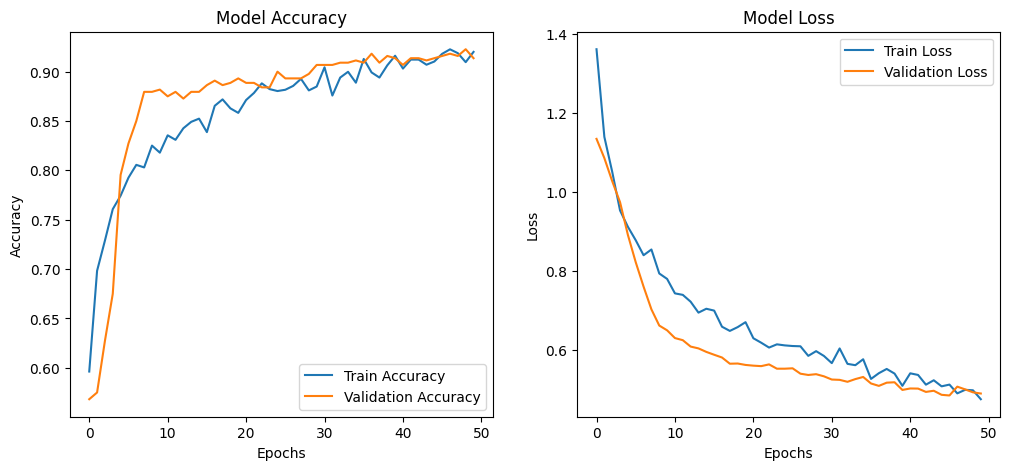

In [16]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [17]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('MCLAHE_Freeze40_0.0001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.8757 - loss: 0.6431
Test Accuracy : 90.54%
Test Loss     : 0.554


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step


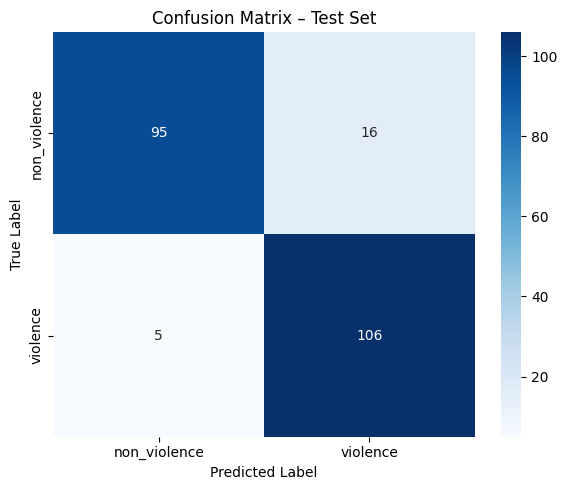


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.95      0.86      0.90       111
    violence       0.87      0.95      0.91       111

    accuracy                           0.91       222
   macro avg       0.91      0.91      0.91       222
weighted avg       0.91      0.91      0.91       222



In [18]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))